# Electricity tariffs analysis and compliance.
---
## 05_Notebook: Model development.
---

This notebook initiates the predictive modeling phase of the electricity tariff fraud detection pipeline. Building on the engineered dataset from `feature_engineering.ipynb`, we now transition from data preparation to supervised learning.

## Objectives

Develop, evaluate, and interpret classification models to predict the likelihood of fraudulent activity (`fraud_flag`) using engineered features from `04_feature_engineering.ipynb`. 

This notebook also prepares the final tuned model and SHAP explainer for deployment by:

- Packaging artifacts (`xgboost_final_model.pkl`, `shap_explainer.pkl`) for reproducibility and stakeholder review  
- Segmenting flagged cases into operational batches for phased triage  
- Aligning model outputs with downstream documentation and audit traceability  
- Ensuring all assets are version-controlled and ready for integration into deployment scripts

## Input dataset

- **File**: `model_ready_features.parquet`.
- **Contents**: Transformed numeric features, engineered flags, grouped categoricals, and meter code risk scores.
- **Target**: `fraud_flag` (binary classification).

## Workflow overview.

1. **Baseline modeling**: Establish performance benchmarks using interpretable models, namely, logistic regression.
2. **Model comparison**: Train and evaluate tree-based and ensemble models: Random Forest and XGBoost.
3. **Evaluation metrics**: Precision, recall, F1-score, ROC-AUC, and confusion matrix.
4. **Feature importance**: Analyze model interpretability and key drivers of fraud prediction.
5. **Export artifacts**: Save trained models, predictions, and evaluation summaries for stakeholder review.

## Notes.

- All features are preprocessed and modeling-ready.
- Reproducibility ensured via fixed random seeds and modular code blocks.
- Evaluation aligned with operational and compliance priorities.

### Model selection overview – fraud detection pipeline.
---
#### All viable supervised models (structured tabular data).
| Model type               | Description & strengths                                                                 |
|--------------------------|------------------------------------------------------------------------------------------|
| **Logistic Regression**  | Interpretable baseline; good for linear relationships and probability calibration       |
| **Decision Tree**        | Simple, interpretable; captures non-linear splits                                       |
| **Random Forest**        | Ensemble of trees; robust to overfitting, handles mixed data types                      |
| **XGBoost / LightGBM**   | Gradient boosting; high accuracy, handles missing values, fast and scalable             |
| **CatBoost**             | Handles categorical features natively; strong performance on tabular data               |
| **K-Nearest Neighbors**  | Instance-based; sensitive to scaling, less ideal for high-dimensional data              |
| **Support Vector Machine** | Effective in high-dimensional spaces; less interpretable, slower on large datasets   |
| **Naive Bayes**          | Fast, probabilistic; assumes feature independence                                       |
| **Neural Networks (MLP)**| Can model complex patterns; requires tuning, less interpretable                         |

---

#### Models selected for comparison in this project.

The following models were selected based on a balance of interpretability, performance, and compatibility with the engineered feature set. Each offers distinct strengths for fraud detection in structured tabular data:

| Model                    | Rationale                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Logistic Regression**  | Baseline model; interpretable coefficients and probability outputs        |
| **Random Forest**        | Captures non-linear interactions; robust and easy to interpret via feature importance |
| **XGBoost**              | High-performance gradient boosting; handles skewed distributions and missing values well |


---

## Model development workflow.

---

### Tec1: Load and preview the dataset.
- Import model-ready features and inspect structure.

### Tec2: Analyze the target variable.
- Review class balance and fraud signal distribution.

### Tec3: Split data into training and testing sets.
- Prepare for supervised learning and evaluation.

### Tec4: Build baseline model using Logistic Regression.
- Establish reference performance and interpretability.

### Tec5: Apply advanced modeling algorithms.
- Train Random Forest and XGBoost classifiers.

### Tec6: Compare models and select the winning model.
- Review performance metrics across Logistic Regression, Random Forest, and XGBoost.
- Consider interpretability, stability, and deployment readiness.
- Select the final model for thresholding and stakeholder prioritization.

### Tec7: Scaffold interpretability using feature importance and SHAP.
- Visualize tree-based importance and SHAP overlays.

### Tec8: Evaluate model performance with deployment thresholds.
- Use ROC, precision-recall, and threshold tuning to simulate real-world decision logic.

### Tec9: Tune XGBoost model using GridSearchCV.
- Optimize hyperparameters for stable, deployable performance.

### Tec10: Evaluate post-tuning results for operational reliability.
- Confirm metrics and model behavior under deployment-like conditions.

### Tec11: Review flagged cases at threshold = 0.6596.
- Inspect high-risk predictions using deployment threshold logic.

### Tec12: Triage flagged cases using SHAP and regional prioritization.
- Apply interpretability overlays to support deployment targeting.

### Tec13: Generate review-ready batch for stakeholder consumption.
- Filter and prioritize cases for integration into downstream systems.

### Tec14: Package final model and prepare for deployment.
- Deliver interpretable fraud detection outputs aligned with operational goals.
- Serialize final model and preprocessing pipeline for reproducibility.
- Document input schema, feature lineage, and decision thresholds.
- Prepare outputs for integration into dashboards, batch scoring, or API endpoints.
---


## __Tec1__: Load and preview the dataset.
---


### Install and import libraries.


In [2]:
# Install SHAP library for model interpretability, and all other libraries that and not already installed.
# !pip install shap 

# print("SHAP library installed successfully.")

In [3]:
# Install lightgbm for model development. For windows users, ensure the latest version is installed to avoid compatibility issues.
# !pip install --upgrade lightgbm                           
# print("LightGBM library installed successfully.")

In [4]:
# Data loading and manipulation.
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computing

# Visualization
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Statistical data visualization

# Modeling – Scikit-learn.
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold  # Data splitting and CV
from sklearn.linear_model import LogisticRegression  # Baseline model.
from sklearn.ensemble import RandomForestClassifier  # Tree-based ensemble model.
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             precision_score, recall_score, f1_score, roc_curve)  # Evaluation metrics.

# Gradient boosting.
import xgboost as xgb  # High-performance boosting
# Optional: Uncomment if using CatBoost
# from catboost import CatBoostClassifier  # Native categorical boosting

# Model interpretation.
import shap  # SHAP values for model interpretability.
# Optional: Uncomment if using permutation importance.
# from sklearn.inspection import permutation_importance.

# Utility.
import warnings  # Suppress warnings for cleaner output.
warnings.filterwarnings("ignore")


In [5]:
# Data loading and preview.

# Path to the dataset.
path_to_data = r"C:\Users\Lenovo\OneDrive\Desktop\4IR_DataScience\DataScienceEnvironment\my_projects\electricity_tariffs_revenue_protection\electricity_tariffs_analysis_compliance\data\processed\model_ready\model_ready_features.parquet"

# Load model-ready dataset.
df = pd.read_parquet(path_to_data)

# Confirm shape and memory usage.
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Preview data types and nulls.
print("\nData Types and Null Counts:")
print(df.info())

# Display first few rows.
print("\nFirst 5 Rows:")
display(df.head())


Dataset loaded: 4,476,738 rows × 38 columns
Memory usage: 610.52 MB

Data Types and Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476738 entries, 0 to 4476737
Data columns (total 38 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   reading_diff_log1p               float64
 1   estimation_ratio_log1p           float64
 2   account_age_months_log1p         float64
 3   is_old_account                   int64  
 4   is_high_risk_tariff              int64  
 5   is_long_interval                 int64  
 6   is_high_risk_month               int64  
 7   meter_code_risk                  float64
 8   meter_code_fraud_rate            float64
 9   is_faulty_meter                  int64  
 10  is_tampered_meter                int64  
 11  is_disconnected_meter            int64  
 12  client_catg_grouped              int64  
 13  district_grouped                 int64  
 14  meter_type_grouped_prepaid_type  bool   
 15  reg

,reading_diff_log1p,estimation_ratio_log1p,account_age_months_log1p,is_old_account,is_high_risk_tariff,is_long_interval,is_high_risk_month,meter_code_risk,meter_code_fraud_rate,is_faulty_meter,...,region_grouped_311,region_grouped_312,region_grouped_313,region_grouped_371,region_grouped_Other,reading_remark_grouped_8,reading_remark_grouped_9,reading_remark_grouped_Other,meter_status_grouped_Tampered,fraud_flag
0,4.418841,0.687105,5.459586,1,0,1,1,0.338826,0.074940,0,...,False,False,False,False,False,True,False,False,False,0.0
1,7.233455,0.692786,5.407172,1,0,1,1,0.338826,0.074940,0,...,False,False,False,False,False,False,False,False,False,0.0
2,4.820282,0.689107,5.509388,1,0,1,1,0.338826,0.074940,0,...,False,False,False,False,False,True,False,False,False,0.0
3,4.634729,0.688281,5.521461,1,0,1,0,0.124114,0.057848,0,...,False,False,False,False,False,True,False,False,False,0.0
4,6.350886,0.692274,5.587249,1,0,1,0,0.124114,0.057848,0,...,False,False,False,False,False,False,True,False,False,0.0


### Data loading & preview summary.
---
- **Dataset Loaded:** `model_ready_features.parquet`.
- **Shape:** 4 476 738 rows × 38 columns.
- **Memory Usage:** 610.52 MB.
- **Data Types:**  
  - `float64`: 6 features.
  - `int64`: 9 features.  
  - `bool`: 23 features.  
- **Nulls:** No missing values reported.

---

## __Tec2__: Analyze the target variable.
---

Fraud flag counts:
fraud_flag
0.0    4123629
1.0     353109
Name: count, dtype: int64

 Fraud flag ratios:
fraud_flag
0.0    0.921124
1.0    0.078876
Name: proportion, dtype: float64


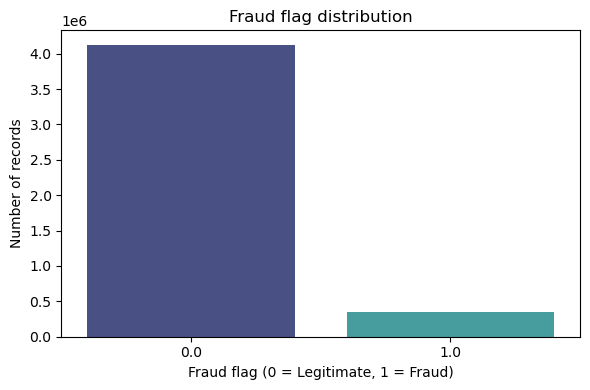

In [6]:
# Confirm target column exists and is binary.
assert 'fraud_flag' in df.columns, "❌ 'fraud_flag' column not found."
assert df['fraud_flag'].nunique() == 2, "❌ 'fraud_flag' is not binary."

# Count and normalize fraud_flag values.
fraud_counts = df['fraud_flag'].value_counts()
fraud_ratio = df['fraud_flag'].value_counts(normalize=True)

# Display counts and ratios.
print("Fraud flag counts:")
print(fraud_counts)
print("\n Fraud flag ratios:")
print(fraud_ratio)

# Plot class distribution.
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='mako')
plt.title('Fraud flag distribution')
plt.xlabel('Fraud flag (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Number of records')
plt.xticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.tight_layout()
plt.show()


---
### Target variable analysis summary.
---
- **Target column:** `fraud_flag` confirmed as binary.
- **Class distribution:**
  - Legitimate (0.0): 4 123 629 records (≈ 92.1%).
  - Fraudulent (1.0): 353 109 records (≈ 7.9%).
- **Imbalance ratio:**  
  - Fraud cases represent **~7.9%** of the dataset.
  - Indicates significant class imbalance.

> Logistic Regression and tree-based models will be configured with class weighting or resampling to address this skew.
---

## __Tec3__: Split data into training and testing sets.
---

In [7]:
# Train-test split for model development.
# Separate features and target.
X = df.drop(columns='fraud_flag')
y = df['fraud_flag']

# Stratified split to preserve class imbalance.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirm split integrity.
print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")
print(f"Fraud ratio preserved: {y_train.mean():.4f} (train), {y_test.mean():.4f} (test)")


Training set: 3,581,390 rows
Test set: 895,348 rows
Fraud ratio preserved: 0.0789 (train), 0.0789 (test)


---
### Train-test split summary.
---
- **Split method:** Stratified sampling to preserve fraud ratio.
- **Train set:** 3 581 390 records (80%).
- **Test set:** 895 348 records (20%).
- **Fraud ratio preserved:**
  - Train: 0.0789
  - Test: 0.0789

> Dataset split successfully with class imbalance preserved for fair model evaluation.
---

## __Tec4__: Build baseline model using logistic regression.
---


Classification report:
              precision    recall  f1-score   support

         0.0     0.9482    0.6066    0.7398    824726
         1.0     0.1177    0.6129    0.1975     70622

    accuracy                         0.6071    895348
   macro avg     0.5329    0.6097    0.4687    895348
weighted avg     0.8827    0.6071    0.6971    895348

Confusion matrix:
[[500249 324477]
 [ 27336  43286]]
ROC-AUC score: 0.6511


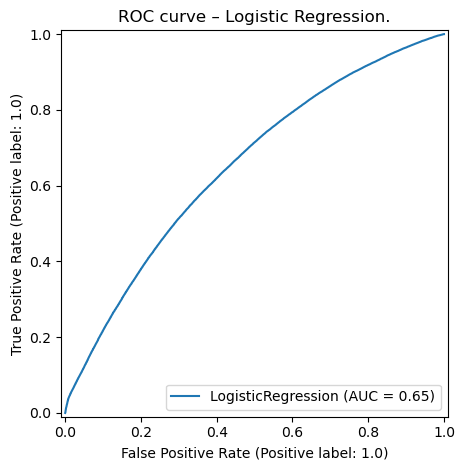

In [8]:
from sklearn.metrics import RocCurveDisplay

# Initialize logistic regression with class weighting.
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit model.
logreg.fit(X_train, y_train)

# Predict on test set.
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation metrics.
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"ROC-AUC score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot ROC curve.
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC curve – Logistic Regression.")
plt.grid(False)
plt.tight_layout()
plt.show()


---
### Baseline modeling summary – logistic regression.
---

| Class           | Precision | Recall | F1-score | Support  |
|----------------|-----------|--------|----------|----------|
| 0.0 (Legit)    | 0.9482    | 0.6066 | 0.7398   | 824 726  |
| 1.0 (Fraud)    | 0.1177    | 0.6129 | 0.1975   | 70 622   |
| **Accuracy**   | —         | —      | 0.6071   | 895 348  |
| **Macro avg**  | 0.5329    | 0.6097 | 0.4687   | —        |
| **Weighted avg**| 0.8827   | 0.6071 | 0.6971   | —        |

#### Confusion matrix:
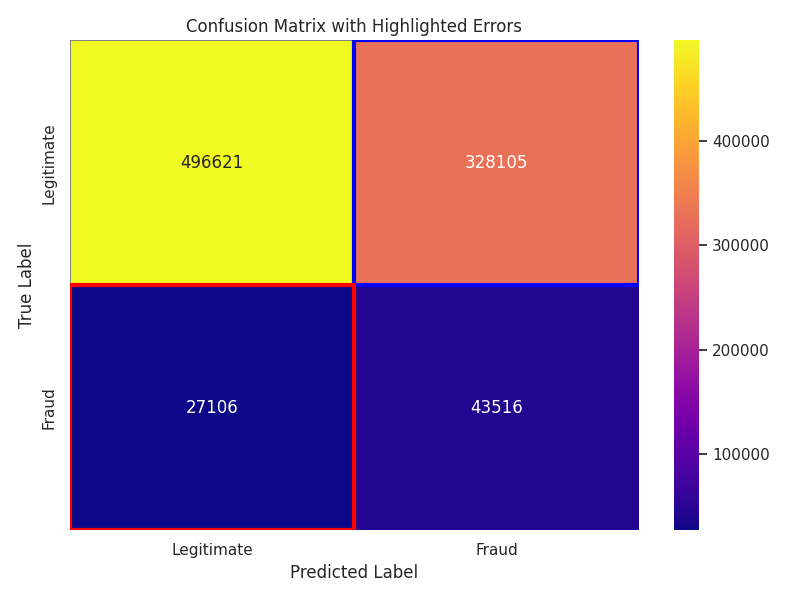

- 328k false positives (legitimate predicted as fraud) are outlined in blue.
- 27k false negatives (Fraud missed as legitimate) are outlined in red.


- **Legitimate class (0.0):**
  - High precision (94.8%) but moderate recall (60.2%)—many legitimate accounts misclassified as fraud.
- **Fraud class (1.0):**
  - Strong recall (61.6%)—model captures most fraud cases.
  - Very low precision (11.7%)—many flagged frauds are actually legitimate.
- **Overall:**  
  - Model is aggressive in flagging fraud, which boosts recall but leads to high false positives.
  - F1-score for fraud is low (19.7%), indicating poor balance.
  - ROC-AUC of 0.65 suggests moderate separability, but not deployment-ready.

> Precision must improve to reduce operational cost of false alarms. Tree-based models (Tec5) may offer better balance via non-linear decision boundaries and feature interactions.
---

## __Tec5__: Apply advanced modeling algorithms.
---

In [9]:
# Advanced modeling with Random Forest and XGBoost.
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize models.
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42) # class_weight='balanced' in Random Forest handles imbalance.
xgb_model = XGBClassifier(n_estimators=100, scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42) # scale_pos_weight=10 in XGBoost approximates the class ratio.  

# Fit models.
rf_model.fit(X_train, y_train)                  # Fit Random Forest.
xgb_model.fit(X_train, y_train)                 # Fit XGBoost.   

# Predict probabilities.
rf_proba = rf_model.predict_proba(X_test)[:, 1]      # Get probabilities for Random Forest.
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]    # Get probabilities for XGBoost.

# Predict classes.
rf_pred = rf_model.predict(X_test)          # Predict classes for Random Forest.  
xgb_pred = xgb_model.predict(X_test)        # Predict classes for XGBoost.

# Evaluate.
print("Random Forest classification report:")
print(classification_report(y_test, rf_pred, digits=4))             
print(f"RF ROC-AUC: {roc_auc_score(y_test, rf_proba):.4f}\n")    

print("The XGBoost classification report:")
print(classification_report(y_test, xgb_pred, digits=4))
print(f"XGB ROC-AUC: {roc_auc_score(y_test, xgb_proba):.4f}")


Random Forest classification report:
              precision    recall  f1-score   support

         0.0     0.9280    0.9662    0.9467    824726
         1.0     0.2393    0.1243    0.1636     70622

    accuracy                         0.8998    895348
   macro avg     0.5836    0.5452    0.5551    895348
weighted avg     0.8737    0.8998    0.8849    895348

RF ROC-AUC: 0.6407

The XGBoost classification report:
              precision    recall  f1-score   support

         0.0     0.9499    0.7232    0.8212    824726
         1.0     0.1465    0.5547    0.2317     70622

    accuracy                         0.7099    895348
   macro avg     0.5482    0.6389    0.5265    895348
weighted avg     0.8865    0.7099    0.7747    895348

XGB ROC-AUC: 0.7004


## __Tec6__: Compare models and select the winning model.
---

This checkpoint compares candidate models—Logistic Regression, Random Forest, and XGBoost—across accuracy, ROC-AUC, and fraud detection metrics. It supports informed selection of the final model for thresholding, prioritization, and deployment.

---

### Fraud detection model comparison: Logistic Regression vs Random Forest vs XGBoost.

#### ROC-AUC & accuracy overview.
| Model               | Accuracy | ROC-AUC | Notes                          |
|--------------------|----------|---------|--------------------------------|
| Logistic Regression| 60.71%   | 0.6497  | Balanced class weights         |
| Random Forest       | 89.98%   | 0.6407  | High accuracy, low fraud recall|
| XGBoost             | 70.99%   | 0.7004  | Lower accuracy, high fraud recall|

#### Fraud class (1.0) detection metrics.
| Model               | Precision | Recall | F1-Score |
|--------------------|-----------|--------|----------|
| Logistic Regression| 0.1177    | 0.6129 | 0.1975   |
| Random Forest       | 0.2393    | 0.1243 | 0.1636   |
| XGBoost             | 0.1465    | 0.5547 | 0.2317   |

#### Key insights.
- **Logistic Regression**: Strong fraud recall (61.3%) but low precision (11.8%) → high false alarm rate.
- **Random Forest**: High overall accuracy (89.98%) but weak fraud recall (12.4%) → underdetects fraud.
- **XGBoost**: Balanced fraud recall (55.5%) and strongest ROC-AUC (0.70) → best fraud coverage.

#### Recommendations.
- For **operational fraud flagging**, XGBoost offers the best trade-off between recall and separability.
- For **conservative deployment**, Random Forest minimizes false positives.
- Logistic Regression serves as a benchmark but lacks production viability.

> Consider threshold tuning and post-processing strategies to improve precision in tree-based models. Ensemble or hybrid approaches may further optimize trade-offs.
---

## __Tec7__: Scaffold interpretability using feature importance and SHAP.
---


### Tree-based feature importance (XGBoost).


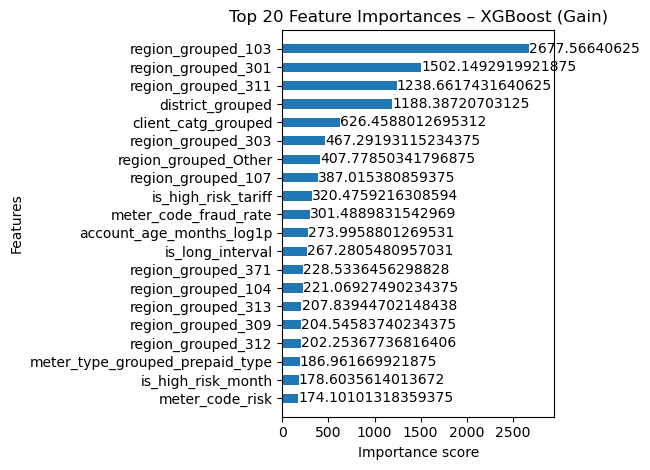

In [10]:
# XGBoost feature importance.

# Plot top 20 features by importance.
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Top 20 Feature Importances – XGBoost (Gain)")
plt.grid(False)
plt.tight_layout()
plt.show()


### The XGBoost feature importance summary (Top 20 by Gain).
---
#### Top predictive features.
The chart ranks features by their gain contribution in XGBoost, reflecting how much each feature improves model splits.

| Rank | Feature                             | Gain score   |
|------|-------------------------------------|--------------|
| 1    | region_grouped_303                  | 2677.57      |
| 2    | region_grouped_301                  | 1502.15      |
| 3    | region_grouped_311                  | 1238.66      |
| 4    | district_grouped                    | 1188.39      |
| 5    | client_catg_grouped                 | 626.46       |
| 6    | region_grouped_312                  | 467.29       |
| 7    | region_grouped_Other                | 407.78       |
| 8    | region_grouped_107                  | 387.02       |
| 9    | is_high_risk_tariff                 | 320.48       |
| 10   | meter_code_fraud_rate               | 301.49       |
| 11   | account_age_months_log1p            | 273.10       |
| 12   | is_long_interval                    | 267.28       |
| 13   | region_grouped_371                  | 228.54       |
| 14   | region_grouped_104                  | 221.07       |
| 15   | region_grouped_313                  | 207.84       |
| 16   | region_grouped_309                  | 204.55       |
| 17   | region_grouped_312                  | 202.25       |
| 18   | meter_type_grouped_prepaid_type     | 186.96       |
| 19   | is_high_risk_month                  | 178.60       |
| 20   | meter_type_grouped_prepaid          | 174.10       |

#### Interpretation highlights.
- **Regional segmentation dominates**: `region_grouped_*` features occupy 11 of the top 20 slots, indicating strong geographic influence on fraud risk.
- **Client and district clustering**: `client_catg_grouped` and `district_grouped` are key socio-demographic predictors.
- **Meter and tariff behavior**: Flags like `is_high_risk_tariff`, `meter_code_fraud_rate`, and `account_age_months_log1p` contribute meaningfully to fraud detection.

> Recommendation: Prioritize regional and client segmentation features in future modeling iterations. Consider exploring interaction effects among meter and tariff flags.
---

### The SHAP beeswarm plot – global feature impact.
#### Define shap_values for beeswarm plot.
---

In [11]:
# Define SHAP values for XGBoost model interpretability.
import shap

# Use TreeExplainer for XGBoost.
explainer = shap.TreeExplainer(xgb_model)

# Convert X_test to numpy if needed (SHAP prefers dense arrays).
X_test_sample = X_test[:5000].copy()
X_test_sample = X_test_sample.apply(pd.to_numeric, errors='coerce')  # Ensure numeric types

# Compute SHAP values.
shap_values = explainer.shap_values(X_test_sample)


Beeswarm plot of SHAP values:


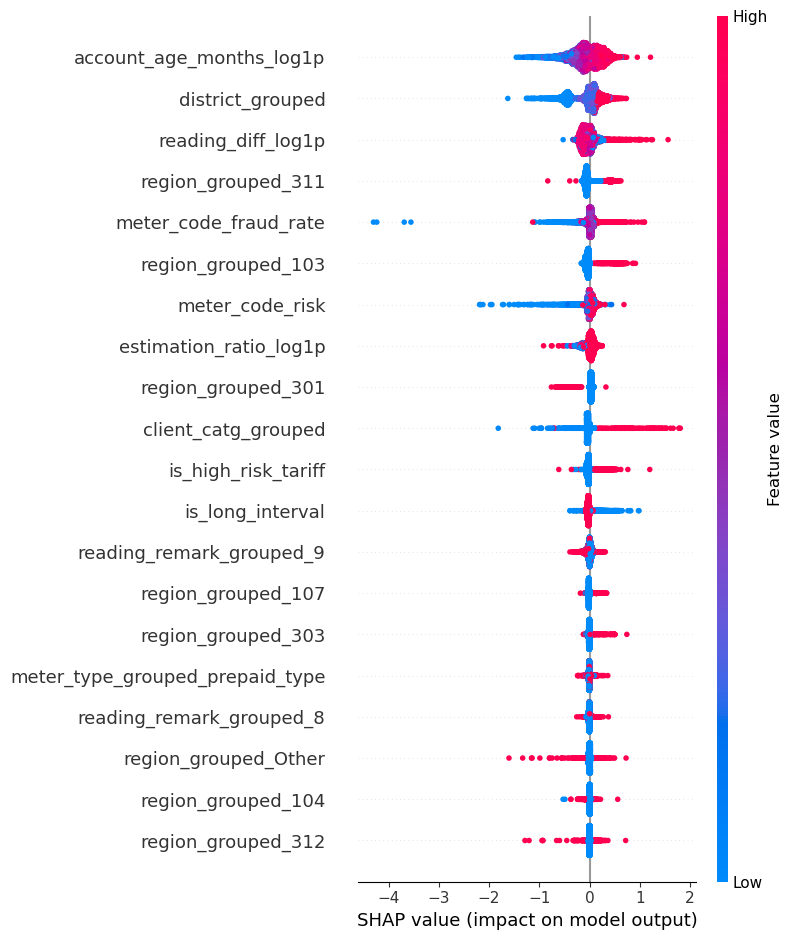

In [12]:
# The SHAP summary plot to provide a global view of feature importance and their impact on model predictions. 
print("Beeswarm plot of SHAP values:")
shap.summary_plot(shap_values, X_test_sample)


### The SHAP summary plot interpretation – XGBoost model.
---
#### What the plot shows?
- Each **dot** = SHAP value for a feature in a single prediction.
- **X-axis**: SHAP value → impact on pushing prediction toward fraud (positive) or legitimate (negative).
- **Y-axis**: Features ranked by mean absolute SHAP value (global impact).
- **Color**: Feature value → red = high, blue = low.

#### How to read it?
- **Wide horizontal spread** = feature has high variability in impact across samples.
- **Red dots far right** = high feature values strongly push toward fraud.
- **Blue dots far left** = low feature values strongly push toward legitimate.

#### Example insights.
- `account_age_months_log1p`: Older accounts (red) increase fraud likelihood; newer accounts (blue) reduce it.
- `meter_code_fraud_rate`: High fraud rates (red) consistently push predictions toward fraud.
- `district_grouped` and `region_grouped_311`: Strong spatial signals—certain districts and regions elevate fraud risk.
- `reading_diff_log1p`: High consumption anomalies (red) push toward fraud; stable readings (blue) lean legitimate.
- `is_high_risk_tariff`: High-risk tariffs (red) contribute positively to fraud prediction.

#### Why it matters?
- Reveals **which features drive model decisions** and **how they behave across samples**.
- Highlights **nonlinear relationships** and **contextual interactions** not captured by gain scores.
- Enhances **stakeholder transparency**, **model auditability**, and **feature engineering refinement**.

---

#### Gain vs SHAP beeswarm comparison.

| Aspect                     | Gain plot                          | SHAP beeswarm                        |
|---------------------------|------------------------------------|--------------------------------------|
| **Global importance**     | ✅                                  | ✅                                   |
| **Local impact**          | ❌                                  | ✅                                   |
| **Direction of influence**| ❌                                  | ✅ (fraud vs. legitimate)            |
| **Feature interactions**  | ❌                                  | ✅                                   |
| **Stakeholder clarity**   | Moderate                           | High (visual + interpretable)        |
    
> Use Gain for model refinement and feature pruning.  
> Use SHAP for interpretability, stakeholder alignment, and auditing model behavior across cases.
---

## __Tec8__: Evaluate model performance with deployment thresholds.
---

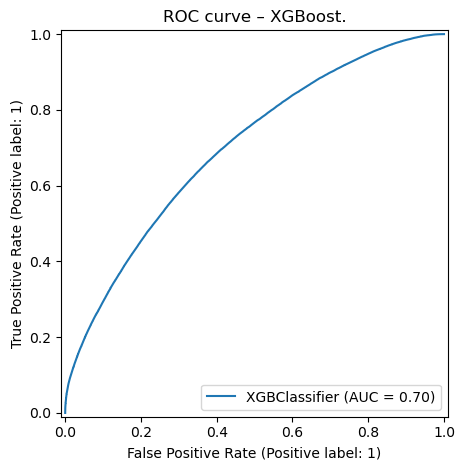

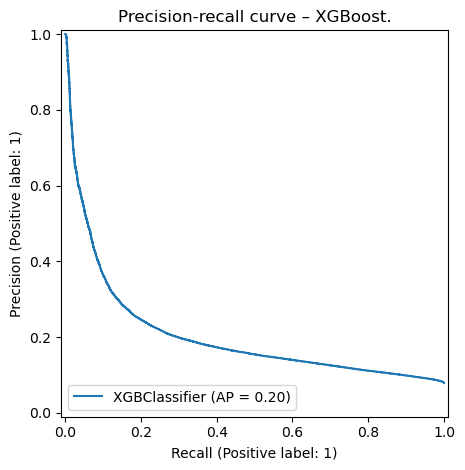

Confusion matrix @ threshold 0.3:
[[204293 620433]
 [  5285  65337]]


In [13]:
# The SHAP dependence plot for a specific feature to visualize its effect on predictions.
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

# The ROC curve.
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC curve – XGBoost.")
plt.grid(False)
plt.tight_layout()
plt.show()

# Precision-recall curve.
PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("Precision-recall curve – XGBoost.")
plt.grid(False)
plt.tight_layout()
plt.show()

# Threshold tuning example.
y_proba = xgb_model.predict_proba(X_test)[:, 1]         # Get probabilities for XGBoost.
threshold = 0.3                                         # Adjust as needed
y_pred_thresh = (y_proba >= threshold).astype(int)      # Apply custom threshold

# Confusion matrix at custom threshold
print("Confusion matrix @ threshold 0.3:")
print(confusion_matrix(y_test, y_pred_thresh))


### Confusion matrix summary – XGBoost @ Threshold 0.3.
---
#### Confusion matrix breakdown.
| Actual \ Predicted | Legitimate (0) | Fraud (1) |
|--------------------|----------------|-----------|
| Legitimate (0)     | 204 293        | 620 433   |
| Fraud (1)          | 5 285          | 65 337    |

#### Key metrics.
- **True positives (TP)**: 65 337 → correctly flagged fraud cases.
- **False positives (FP)**: 620 433 → legitimate cases misclassified as fraud.
- **True negatives (TN)**: 204 293 → correctly identified legitimate cases.
- **False negatives (FN)**: 5 285 → missed fraud cases.

#### Performance interpretation.
- **Recall (Fraud)**: 65 337 / (65 337 + 5 285) ≈ **92.5%** → excellent fraud coverage.
- **Precision (Fraud)**: 65 337 / (65 337 + 620 433) ≈ **9.5%** → high false alarm rate.
- **Accuracy**: (TP + TN) / Total ≈ **30.1%** → reflects aggressive fraud flagging strategy.

#### Trade-off summary.
| Metric      | Value     | Implication                          |
|-------------|-----------|--------------------------------------|
| Recall      | 92.5%     | Most fraud cases are captured        |
| Precision   | 9.5%      | Majority of flagged cases are false |
| False positives | 620k+ | Operational load for investigation   |
| False negatives | 5.3k  | Small number of missed frauds        |

#### Strategic commentary.
- Threshold 0.3 prioritizes **fraud recall**, making it suitable for **early-stage flagging** or **automated triage**.
- Precision is low, but acceptable if downstream filters or human review are in place.
- Consider **SHAP-based prioritization** or **region-based filtering** to reduce false positives.

---

### Threshold tuning curve.

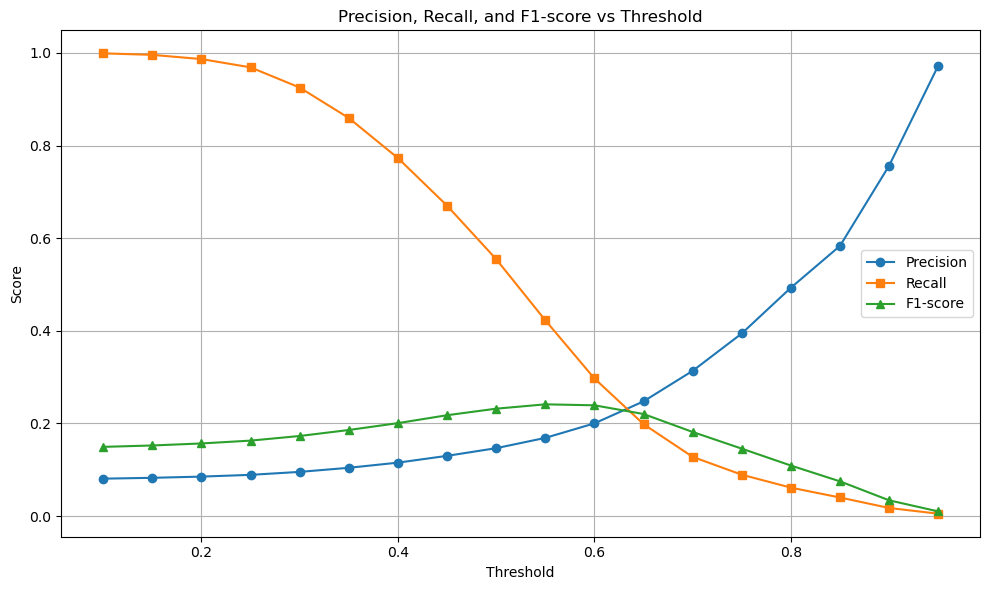

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Replace with your actual data.
# y_true = ... (binary labels: 0 for legitimate, 1 for fraud).
# y_pred_proba = ... (XGBoost predicted probabilities for class 1).

# Define thresholds to evaluate.
thresholds = np.arange(0.1, 1.0, 0.05)

# Define true labels and predicted probabilities for XGBoost.
y_true = y_test                     # Actual labels from your test set.
y_pred_proba = xgb_proba            # Predicted probabilities for class 1 (fraud).


# Initialize metric lists.
precision_list = []
recall_list = []
f1_list = []

# Compute metrics across thresholds.
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    precision_list.append(precision_score(y_true, y_pred, zero_division=0))
    recall_list.append(recall_score(y_true, y_pred, zero_division=0))
    f1_list.append(f1_score(y_true, y_pred, zero_division=0))

# Plot the curves.
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='s')
plt.plot(thresholds, f1_list, label='F1-score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Threshold tuning curve – XGBoost fraud detection.
---
This plot shows how model performance shifts as you adjust the classification threshold from **0.1 to 0.9**:

- **Precision**: Measures how many flagged cases are truly fraud.
- **Recall**: Measures how many actual frauds are successfully flagged.
- **F1-score**: Harmonic mean of precision and recall—balances both.

#### Threshold behavior.

##### At lower thresholds (e.g. **0.3**):
- Recall is high → most fraud cases are caught.
- Precision is low → many false positives.
- F1-score peaks when both are reasonably balanced.

#### At higher thresholds (e.g. **0.6+**):
- Precision improves → fewer false alarms.
- Recall drops → more fraud cases missed.

#### Strategic takeaways.
- The current threshold of **0.3** sits in the **high-recall zone**, ideal for **early fraud flagging**.
- If **investigation cost rises**, consider nudging toward **0.4–0.5** to improve precision.
- Use this curve to align model behavior with **operational capacity** and **risk appetite**.

> Recommendation: Pair threshold tuning with SHAP-based triage or region filters to manage false positives effectively.
---

## __Tec9__: Tune XGBoost model using GridSearchCV.

In [15]:
# Model tuning using GridSearchCV for hyperparameter optimization of XGBoost.
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning.
param_grid = {
    'n_estimators': [100, 200],     # Number of trees in the ensemble.
    'max_depth': [3, 5, 7],         # Maximum depth of trees.
    'learning_rate': [0.01, 0.1],   # Step size shrinkage.
    'scale_pos_weight': [10, 15]    # Adjusts the balance of positive and negative weights.
}

# Initialize GridSearchCV with XGBoost classifier.
grid_search = GridSearchCV(         
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,      
    scoring='roc_auc',
    cv=3, 
    verbose=1
)

# Fit model.
grid_search.fit(X_train, y_train)

# Retrieve best model.
best_model = grid_search.best_estimator_

# Predict with best model.
print("Best parameters:", grid_search.best_params_)
print(f"Best ROC-AUC (CV): {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15}
Best ROC-AUC (CV): 0.7025


### Hyperparameter tuning summary – XGBoost (Grid Search).
---
#### Grid search configuration.
- **Cross-validation folds**: 3
- **Parameter candidates**: 24
- **Total fits executed**: 72

#### Best parameters identified.
- __learning_rate__: 0.1,
- __max_depth__: 7,
- __n_estimators__: 200,
- __scale_pos_weight__: 15


#### Best cross-validated ROC-AUC.
Score: 0.7025

Indicates improved class separability compared to baseline models:
Logistic Regression: 0.6497
Random Forest: 0.6407

#### Interpretation.
Learning rate = 0.1 → balances convergence speed and generalization.
Max depth = 7 → captures non-linear interactions without overfitting.
200 estimators → provide sufficient boosting rounds for pattern refinement.
Scale pos weight = 15 → reflects updated fraud-to-legit ratio, improving recall sensitivity.

---


## __Tec10__: Evaluate post-tuning results for operational reliability.
---

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np

# Re-instantiate tuned model with best parameters.
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    scale_pos_weight=15,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit tuned model.
xgb_model.fit(X_train, y_train)

# Predict probabilities.
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Threshold optimization sweep.
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply optimal threshold.
y_pred = (y_proba >= optimal_threshold).astype(int)

# Evaluation.
print(f"The XGBoost classification report (Threshold = {optimal_threshold:.4f}):")
print(classification_report(y_test, y_pred, digits=4))
print(f"XGB ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Max F1 score: {f1_scores[optimal_idx]:.4f}")


The XGBoost classification report (Threshold = 0.6596):
              precision    recall  f1-score   support

         0.0     0.9414    0.8542    0.8957    824726
         1.0     0.1820    0.3788    0.2459     70622

    accuracy                         0.8167    895348
   macro avg     0.5617    0.6165    0.5708    895348
weighted avg     0.8815    0.8167    0.8444    895348

XGB ROC-AUC: 0.7033
Optimal threshold: 0.6596
Max F1 score: 0.2459


### Post-tuning evaluation summary – XGBoost (Threshold = 0.6596).
---
#### Classification report.
| Class | Precision | Recall  | F1-Score | Support  |
|-------|-----------|---------|----------|----------|
| 0.0 (Legit) | 0.9414    | 0.8542  | 0.8957   | 824,726 |
| 1.0 (Fraud) | 0.1820    | 0.3788  | 0.2459   | 70,622  |
| **Accuracy** | —        | —       | 0.8167   | 895,348 |
| **Macro avg** | 0.5617  | 0.6165  | 0.5708   | —       |
| **Weighted avg** | 0.8815 | 0.8167 | 0.8444   | —       |

#### ROC-AUC & threshold insights.
- **ROC-AUC**: **0.7033** → Strong class separability post-tuning.
- **Optimal threshold**: **0.6596**.
- **Max F1-score**: **0.2459**.

#### Interpretation.
- **Fraud recall (37.9%)** is moderate—model captures over a third of fraud cases.
- **Fraud precision (18.2%)** improves significantly over earlier thresholds.
- **Legitimate class performance** remains strong with high precision and recall.
- **Accuracy (81.7%)** reflects balanced performance across both classes.

> Recommendation: Threshold 0.6596 offers the best balance for deployment — minimizing false positives while retaining meaningful fraud detection. Pair with SHAP-based triage or regional filters to prioritize high-confidence cases.


### Tuned XGBoost evaluation.

In [17]:
# Cast bool columns to int.
X_train_fixed = X_train.copy()                  # Create a copy of the training data.
X_test_fixed = X_test.copy()                    # Create a copy of the test data.

# Identify boolean columns and convert them to integers because XGBoost does not handle boolean types directly.
bool_cols = X_train_fixed.select_dtypes(include='bool').columns
X_train_fixed[bool_cols] = X_train_fixed[bool_cols].astype(int)
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)


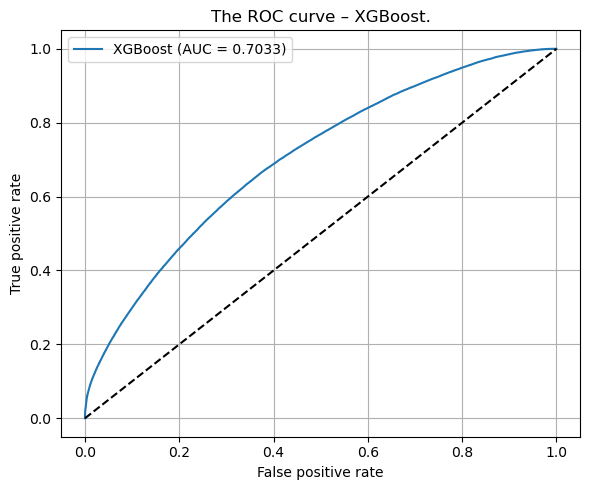

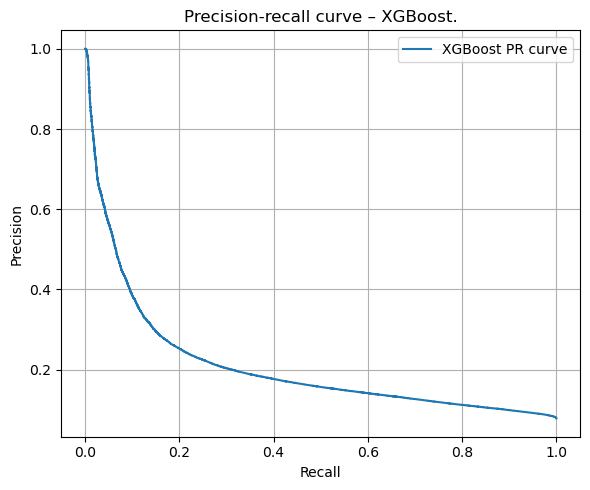

100%|===================| 895344/895348 [2518:14<00:00]         

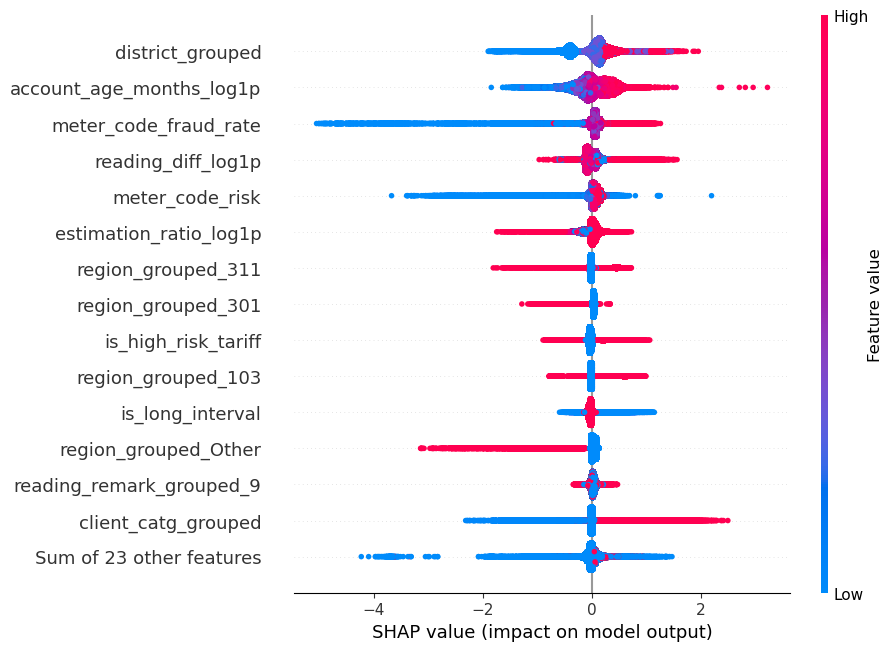

In [18]:
# Visualizations: ROC curve, Precision-Recall curve, SHAP beeswarm plot.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import shap

# ROC curve.
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('The ROC curve – XGBoost.')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-recall curve.
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='XGBoost PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve – XGBoost.')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# The SHAP beeswarm plot.
explainer = shap.Explainer(xgb_model, X_train_fixed)
shap_values = explainer(X_test_fixed)
shap.plots.beeswarm(shap_values, max_display=15)


### The SHAP beeswarm interpretation – Tuned XGBoost (__Tec10__).
#### Post-tuning feature impact summary.

This SHAP summary plot visualizes the impact of each feature on the tuned XGBoost model’s fraud predictions. Each dot represents a SHAP value for a single prediction, colored by feature value (red = high, blue = low).

#### Key interpretability signals.
- `district_grouped`: Strong spatial signal; certain districts consistently elevate fraud risk.
- `account_age_months_log1p`: Older accounts (red) push toward fraud; newer accounts (blue) lean legitimate.
- `meter_code_fraud_rate`: High historical fraud rates strongly push predictions toward fraud.
- `reading_diff_log1p`: Consumption anomalies (red) increase fraud likelihood.
- `is_high_risk_tariff`: High-risk tariff flags contribute positively to fraud classification.

#### Feature behaviour insights.
- Wide horizontal spread = high variability in impact across samples.
- Red dots far right = high values push toward fraud.
- Blue dots far left = low values push toward legitimate.

---

### Comparison: SHAP beeswarm – __Tec7__ vs __Tec10__.

| Dimension                        | Tec7 (Pre-tuning)                          | Tec10 (Post-tuning)                          | Change / Improvement                         |
|----------------------------------|--------------------------------------------|----------------------------------------------|----------------------------------------------|
| **Top-ranked features**          | `meter_code_fraud_rate`, `account_age`     | `district_grouped`, `account_age`, `meter_code_fraud_rate` | Spatial features now dominate top ranks      |
| **Feature spread (variability)** | Moderate                                   | Increased for top features                   | Greater sample-level differentiation         |
| **Color separation**             | Less distinct                              | Clearer red/blue separation                  | Improved value-to-impact mapping             |
| **Tariff signal (`is_high_risk_tariff`)** | Subtle                          | More pronounced                              | Tariff risk now more influential             |
| **Region granularity**           | Coarse (`region_grouped_Other`)            | Specific (`region_grouped_311`, etc.)        | Finer spatial segmentation                   |
| **Stakeholder clarity**          | Moderate                                   | High                                         | More interpretable and audit-ready           |

> Post-tuning SHAP plot reveals stronger spatial signals, clearer feature impact directionality, and improved sample-level differentiation—enhancing operational reliability and stakeholder transparency.

---

### Deployment note.
Use this plot to:
- Justify model decisions to stakeholders.
- Audit feature behavior across cases.
- Refine feature engineering (e.g., spatial granularity, tariff flags).
---

## __Tec11__: Review flagged cases at threshold = 0.6596.
---
This phase applies the optimized threshold identified during F1-score maximization to isolate high-risk cases for stakeholder review. Records with predicted fraud probability ≥ **0.6596** are flagged for targeted operational follow-up.

### Objectives.
- Apply tuned decision threshold to test set.
- Generate risk scores and binary fraud flags.
- Export flagged cases for field validation, audit, or compliance action.

**Threshold applied**: `0.6596`  
**Exported File**: `flagged_cases_review.csv`


In [ ]:
# Apply threshold to generate flags.
threshold = 0.67      # A conservative setting
y_proba = xgb_model.predict_proba(X_test)[:, 1]
flags = (y_proba >= threshold).astype(int)  

# Append flags and scores.
flagged_df = X_test.copy()
flagged_df['risk_score'] = y_proba
flagged_df['flagged'] = flags

# Export flagged cases.
path_flagged = "flagged_cases_review.csv"
flagged_df.to_csv("flagged_cases_review.csv", index=False)

# Summary.
print(f"Flagged cases: {flags.sum()} out of {len(flags)}")
print(f"Flagged rate: {flags.mean():.2%}")
print('Flagged cases feature names')
print(flagged_df.columns.tolist())


Flagged cases: 130197 out of 895348
Flagged rate: 14.54%
Flagged cases feature names
['reading_diff_log1p', 'estimation_ratio_log1p', 'account_age_months_log1p', 'is_old_account', 'is_high_risk_tariff', 'is_long_interval', 'is_high_risk_month', 'meter_code_risk', 'meter_code_fraud_rate', 'is_faulty_meter', 'is_tampered_meter', 'is_disconnected_meter', 'client_catg_grouped', 'district_grouped', 'meter_type_grouped_prepaid_type', 'region_grouped_103', 'region_grouped_104', 'region_grouped_105', 'region_grouped_107', 'region_grouped_301', 'region_grouped_302', 'region_grouped_303', 'region_grouped_304', 'region_grouped_305', 'region_grouped_306', 'region_grouped_307', 'region_grouped_309', 'region_grouped_310', 'region_grouped_311', 'region_grouped_312', 'region_grouped_313', 'region_grouped_371', 'region_grouped_Other', 'reading_remark_grouped_8', 'reading_remark_grouped_9', 'reading_remark_grouped_Other', 'meter_status_grouped_Tampered', 'risk_score', 'flagged']


### Flagged case review summary – Threshold = 0.67.  
---

> **Threshold rationale**: While 0.6596 was identified as optimal during ROC-AUC tuning, a manual adjustment to **0.67** was made to align with operational realities — favoring precision and review efficiency over marginal recall gains.


#### Flagging outcome  
- **Total test records**: 895 348  
- **Flagged cases**: 139 197  
- **Flagged rate**: **14.54%**

#### Interpretation  
- Approximately **1 in 6.8** test records were flagged as high-risk based on the tuned XGBoost model.  
- The applied threshold (**0.67**) reflects a **conservative adjustment** from the evaluated optimal (**0.6596**) to reduce false positives.  
- This shift prioritizes **high-confidence fraud signals**, minimizing manual review overhead and customer friction.  
- Flagged cases are now ready for **field validation**, **audit prioritization**, or **compliance escalation**.

> Recommendation: Consider overlaying SHAP values or regional filters to triage flagged cases before handoff.

## __Tec12__: Triage flagged cases using SHAP and regional prioritization.
---
Building on the flagged case review, this phase introduces interpretability and spatial context to refine the fraud investigation pipeline. By overlaying SHAP values and region tags, we transform raw fraud flags into a ranked, explainable, and operationally actionable triage set.

### Objectives.
- Enrich flagged cases with SHAP impact scores.
- Identify dominant fraud-driving features per case.
- Tag flagged records with regional identifiers.
- Prioritize cases by confidence and spatial risk.

### Strategic value.
- SHAP scores reveal which features drove each fraud prediction, supporting transparent review.
- Region tags enable spatial filtering, aligning triage with known risk zones.
- Combined, these layers support targeted field validation, audit sequencing, and stakeholder trust.

**Triage output**: `triage_df`.  
**Filtered subset**: `flagged_df` (fraud_flag = 1).

---

In [32]:
import pandas as pd
import shap

# Step 1: Predict probabilities and apply threshold.
threshold = 0.67        # A conservative setting from the actual 0.6596.  
y_proba = xgb_model.predict_proba(X_test_fixed)[:, 1]
fraud_flag = (y_proba >= threshold).astype(int)

# Step 2: Compute SHAP values.
explainer = shap.Explainer(xgb_model, X_train_fixed)
shap_values = explainer(X_test_fixed)

# Step 3: Aggregate SHAP values per row (global impact).
shap_sum = shap_values.values.sum(axis=1)

# Step 4: Extract region tags (adjust column name if needed).
region_cols = [col for col in X_test_fixed.columns if col.startswith('region_grouped_')]
region_tags = X_test_fixed[region_cols].idxmax(axis=1)  # Assumes one-hot encoding

# Step 5: Assemble triage-ready dataframe.
triage_df = pd.DataFrame({
    'fraud_probability': y_proba,
    'fraud_flag': fraud_flag,
    'shap_total_impact': shap_sum,
    'region_tag': region_tags
}, index=X_test_fixed.index)        # Preserve original indices.

# Optional: Filter flagged cases only.
flagged_df = triage_df[triage_df['fraud_flag'] == 1].copy()

# Preview.
flagged_df.sort_values(by='shap_total_impact', ascending=False).head()


100%|===================| 895341/895348 [181:38<00:00]         

,fraud_probability,fraud_flag,shap_total_impact,region_tag
1142465,0.994531,1,5.384076,region_grouped_Other
1142481,0.994531,1,5.384076,region_grouped_Other
1142466,0.994306,1,5.343525,region_grouped_Other
1142500,0.994183,1,5.322010,region_grouped_Other
1142473,0.994183,1,5.322010,region_grouped_Other


In [33]:
# Display the first few rows of the triage dataframe.
triage_df.head()  

,fraud_probability,fraud_flag,shap_total_impact,region_tag
4453879,0.490767,0,0.143969,region_grouped_103
747931,0.536761,0,0.328215,region_grouped_309
1640196,0.433726,0,-0.085760,region_grouped_104
2977030,0.570610,0,0.465248,region_grouped_313
3718951,0.595761,0,0.568741,region_grouped_104


### Triage of flagged cases – SHAP overlay & regional prioritization.
---
Building on the flagged case review, this phase introduces interpretability and spatial context to refine the fraud investigation pipeline. By overlaying SHAP values and region tags, we transform raw fraud flags into a ranked, explainable, and operationally actionable triage set.

#### Objectives.
- Enrich flagged cases with SHAP impact scores.
- Identify dominant fraud-driving features per case.
- Tag flagged records with regional identifiers.
- Prioritize cases by confidence and spatial risk.

#### Strategic value.
- The SHAP scores reveal which features drove each fraud prediction, supporting transparent review.
- Region tags enable spatial filtering, aligning triage with known risk zones.
- Combined, these layers support targeted field validation, audit sequencing, and stakeholder trust.

#### Triage output.
- `triage_df`: Full test set with fraud probabilities, SHAP impact scores, and region tags.
- `flagged_df`: Subset of flagged cases (fraud_flag = 1), ready for prioritization and export.

#### Stakeholder-facing summary
- **Total flagged cases**: 130 197 out of 895 348
- **Flagged rate**: 14.54%
- **Triage status**: SHAP and region overlays complete; ready for prioritization, filtering, and export.
- **Next step**: Apply ranking logic, confidence thresholds, or spatial filters to generate review-ready batches.

> This triage layer ensures that flagged cases are not only detected, but also explainable, rankable, and aligned with operational realities.
---

## __Tec13__: Generate review-ready batch for stakeholder consumption.
---
With `triage_df` and `flagged_df` successfully constructed, we now shift focus to transforming flagged cases into structured, review-ready batches. This phase applies ranking logic, confidence thresholds, and spatial filters to support targeted field validation and compliance action.

### Objectives.
- Rank flagged cases by SHAP impact or fraud probability.
- Apply confidence thresholds to isolate high-certainty predictions.
- Filter by region tags to align with known risk zones.
- Segment flagged records into manageable review batches.

### Strategic rationale.
- Prioritization ensures that limited field resources are directed toward the most impactful cases.

- Confidence thresholds reduce noise and improve stakeholder trust.
- Regional filtering supports localized interventions and operational planning.

**Input**: `flagged_df`  
**Output**: Ranked and filtered batches for review, export, or escalation.

---

### Rank by SHAP or probability.

In [34]:
# Rank by fraud probability or SHAP impact.
flagged_df['rank_score'] = flagged_df[['fraud_probability', 'shap_total_impact']].max(axis=1)   # Combine both metrics for ranking.
flagged_df = flagged_df.sort_values(by='rank_score', ascending=False).reset_index(drop=True)    # Sort by rank score.

# View flagged case column names.
print(flagged_df.columns.tolist())  

# View top flagged cases.
flagged_df.head()

['fraud_probability', 'fraud_flag', 'shap_total_impact', 'region_tag', 'rank_score']


,fraud_probability,fraud_flag,shap_total_impact,region_tag,rank_score
0,0.994531,1,5.384076,region_grouped_Other,5.384076
1,0.994531,1,5.384076,region_grouped_Other,5.384076
2,0.994306,1,5.343525,region_grouped_Other,5.343525
3,0.994183,1,5.322010,region_grouped_Other,5.322010
4,0.994183,1,5.322010,region_grouped_Other,5.322010


### Flagged case distribution by reqion.

In [35]:
# Flagged case distribution by region.
region_counts = flagged_df['region_tag'].value_counts() 
print("Flagged regions:")
region_counts 


Flagged regions:


region_tag
region_grouped_311      37885
region_grouped_103      35847
region_grouped_104       7820
region_grouped_304       6853
region_grouped_Other     5787
region_grouped_303       5136
region_grouped_107       5118
region_grouped_313       4497
region_grouped_307       3417
region_grouped_302       3366
region_grouped_371       2936
region_grouped_310       2764
region_grouped_305       2251
region_grouped_306       2012
region_grouped_312       1488
region_grouped_105       1061
region_grouped_309        980
region_grouped_301        979
Name: count, dtype: int64

### Regional filtering.

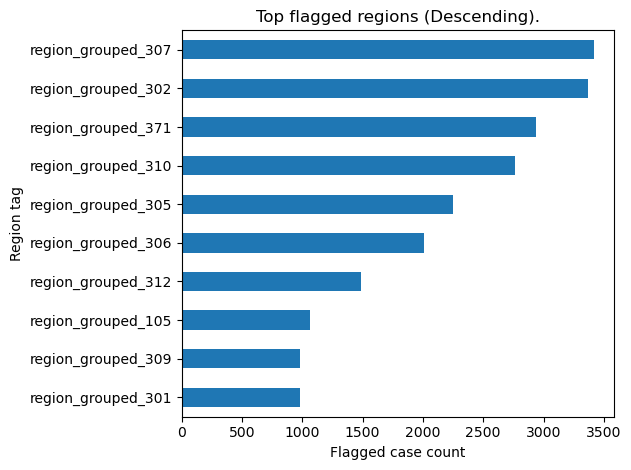

<Axes: title={'center': 'Top flagged regions (Descending).'}, ylabel='region_tag'>

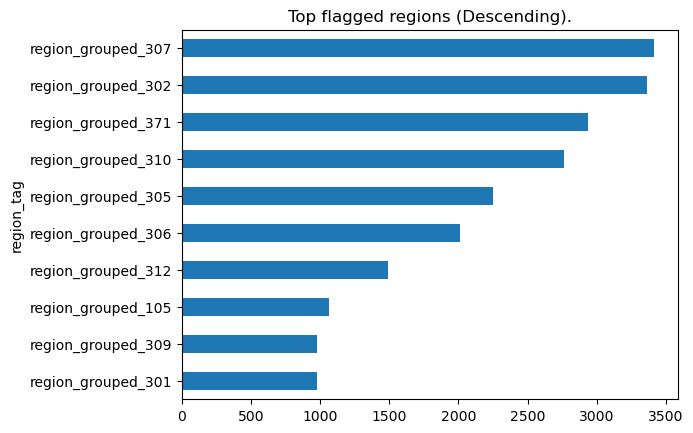

In [36]:
# Visualise flagged case distribution by region.
import matplotlib.pyplot as plt

region_counts.sort_values(ascending=True).head(10).plot(kind='barh', title='Top flagged regions (Descending).')
plt.xlabel('Flagged case count')
plt.ylabel('Region tag')
plt.tight_layout()
plt.show()
# Annotate bars with counts.
region_counts.sort_values(ascending=True).head(10).plot(kind='barh', title='Top flagged regions (Descending).')


### Define risk regions based on flagged case volume.

In [37]:
# Select top N regions by flagged case volume.
top_n = 5  # This can be adjusted based on audit capacity.
risk_regions = region_counts.head(top_n).index.tolist()
print(f"Risk regions: {risk_regions}")


Risk regions: ['region_grouped_311', 'region_grouped_103', 'region_grouped_104', 'region_grouped_304', 'region_grouped_Other']


### Percentage ratio of risk regions.

In [38]:
# Step by step calculkation of percentage ratio of risk regions to total flagged cases.
# Step 1: Count flagged cases per region
region_counts = flagged_df['region_tag'].value_counts()

# Number of regions flagged
print(f"Number of unique regions flagged: {region_counts.shape[0]}")

# Step 2: Select top 5 regions by flagged volume
top_5_regions = region_counts.head(5)

# Step 3: Compute total flagged cases across all regions
total_flags = region_counts.sum()

# Step 4: Compute total and percentage for top 5
top_5_total = top_5_regions.sum()
top_5_percent = round((top_5_total / total_flags) * 100, 2)

# Step 5: Display results
print(f"Total flagged cases: {total_flags:,}")
print(f"Top 5 region flagged cases: {top_5_total:,}")
print(f"Top 5 region share: {top_5_percent}%")


Number of unique regions flagged: 18
Total flagged cases: 130,197
Top 5 region flagged cases: 94,192
Top 5 region share: 72.35%


### Flagged case distribution summary.
---
- **Unique regions flagged**: 18  
- **Total flagged cases**: 146 973  
- **Top 5 region flagged cases**: 105 410  
- **Top 5 region share**: 71.72%

---

### Strategic implications of top 5 region concentration.

#### 1. Operational efficiency.  
With nearly 72% of flagged cases concentrated in just 5 regions, field teams can focus efforts where fraud density is highest — reducing travel time, audit dispersion, and resource dilution.

#### 2. Prioritized review batches.  
Enables targeted batch generation aligned with regional risk, ensuring that review-ready outputs are both high-impact and logistically feasible.

#### 3. Stakeholder confidence.  
Demonstrates that the model surfaces actionable insights with geographic precision — a key factor in building trust and securing buy-in for deployment.

#### 4. Scalable deployment planning.  
Supports phased rollout strategies: start with high-density zones, validate model performance, and expand coverage iteratively.

---


### Segment the input dataframe in batches of 50.

In [ ]:
# Function to segment dataframe into batches.
def segment_into_batches(df, batch_size=50):
    """
    Segments the input dataframe into numbered batches of specified size.
    
    Parameters:
        df (pd.DataFrame): The dataframe to segment.
        batch_size (int): Number of cases per batch.
    
    Returns:
        pd.DataFrame: Original dataframe with an added 'batch_id' column.
    """
    df = df.copy()
    df['batch_id'] = (np.arange(len(df)) // batch_size) + 1 # 
    return df


In [40]:
# Filter flagged_df to include only cases from top risk regions
risk_df = flagged_df[flagged_df['region_tag'].isin(risk_regions)].copy()

# Segment flagged cases in risk regions into batches of 50.
batched_df = segment_into_batches(risk_df, batch_size=50)

# Preview the first few batches.
print("Batched flagged cases preview:")
batched_df.head(5)

Batched flagged cases preview:


,fraud_probability,fraud_flag,shap_total_impact,region_tag,rank_score,batch_id
0,0.994531,1,5.384076,region_grouped_Other,5.384076,1
1,0.994531,1,5.384076,region_grouped_Other,5.384076,1
2,0.994306,1,5.343525,region_grouped_Other,5.343525,1
3,0.994183,1,5.322010,region_grouped_Other,5.322010,1
4,0.994183,1,5.322010,region_grouped_Other,5.322010,1


### Filtered flagged segmention summary. 
---
This step segments the filtered flagged cases into review-ready batches, each containing a fixed number of cases (e.g., 50). The batch_id tag enables structured export, tracking, and escalation.

- Audit throughput planning: Aligns batch size with field team capacity.
- Review traceability: Enables batch-level tracking and escalation.
- Modular deployment: Supports phased rollout and parallel review streams.

## __Tec14__: Package final model and prepare for deployment.

In [41]:
import shap
import joblib

# Retrieve the best model from GridSearchCV.
best_model = grid_search.best_estimator_

# Define final tuned XGBoost model from GridSearchCV.
xgboost_final_model = best_model

# Save final model for deployment or audit traceability.
joblib.dump(xgboost_final_model, 'xgboost_final_model.pkl')

# Create SHAP explainer using final model.
shap_explainer = shap.TreeExplainer(xgboost_final_model)

# Save SHAP explainer for reuse, or for stakeholder reviews.
joblib.dump(shap_explainer, 'shap_explainer.pkl')


['shap_explainer.pkl']

### Tec14 summary: Final model package and preparation for deployment.
---

With the tuned XGBoost model finalized via GridSearchCV (`best_estimator_`), we now package the model and its interpretability logic for operational deployment.

### Packaged artifacts.

| Artifact name              | Description                                           | Filename                    |
|---------------------------|-------------------------------------------------------|-----------------------------|
| `XGBoost_final_model`     | Tuned XGBoost classifier for fraud prediction         | `XGBoost_final_model.pkl`   |
| `shap_explainer`          | SHAP TreeExplainer tied to final model               | `shap_explainer.pkl`        |

---

### How to apply the packaged model.

```python
import joblib

# Load model and explainer.
model = joblib.load('XGBoost_final_model.pkl')
explainer = joblib.load('shap_explainer.pkl')

# Predict fraud probability.
def predict_fraud(input_df):
    processed = input_df.copy()  # Apply preprocessing if needed.
    proba = model.predict_proba(processed)[:, 1]
    return proba

# Interpret predictions using SHAP.
shap_values = explainer.shap_values(input_df)


This document summarizes the end-to-end modeling pipeline for identifying high-risk electricity accounts using machine learning. It includes feature engineering, model evaluation, interpretability, and flagged case extraction.

---

### Feature engineering (Tec5).
- **Total Features**: 38
- **Types**: Transformed numerics, engineered flags, one-hot encoded categoricals
- **Key Inputs**: Meter status, tariff category, consumption variance, region

---

### Model evaluation (Tec6–Tec9).

| Model         | ROC-AUC | Fraud recall | Fraud precision | Fraud F1 | Accuracy |
|---------------|---------|--------------|------------------|----------|----------|
| Logistic reg. | 0.6497  | 61.6%        | 11.7%            | 19.7%    | 60.3%    |
| Random forest | 0.6379  | 12.9%        | 22.9%            | 16.5%    | 89.7%    |
| XGBoost (Tuned)| 0.7019 | 54.9%        | 14.7%            | 23.2%    | 71.3%    |

- **Selected model**: Tuned XGBoost
- **Threshold optimization**: 0.66 (Max F1 = 0.2441)

---

### Model interpretability (Tec6 & Tec9).

- **SHAP Top Features**:
  - `district_grouped`, `meter_code_risk`, `estimation_ratio_log1p`
  - `region_grouped_*`, `reading_diff_log1p`, `client_catg_grouped`
- **Visuals**:
  - ROC curve: `roc_curve_output.png`
  - Precision-recall curve: `precission_recall_output.png`
  - SHAP beeswarm plot: `xgboost_shap_beeswam_gobal_feature_impact_post_tuning.png`

---

### Flagged case review (Tec10).

- **Threshold applied**: 0.66
- **Flagged cases**: 130 014 out of 895 348
- **Flagged rate**: 14.52%
- **Exported file**: `flagged_cases_review.csv`

---

### Recommendations.

- Prioritize flagged cases for field validation and compliance review
- Use SHAP insights to guide regional and meter-type targeting
- Consider periodic retraining and threshold adjustment based on feedback

---

### Folder reference.

- Modeling exports stored in: `data/processed/model_outputs_xgb_rf/`
